In [22]:
# Importation des bibliothèques
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

# Chargement du fichier appearances.csv
df = pd.read_csv('appearances.csv')
# Chargement du fichier players.csv pour récupérer la colonne 'position'
players_df = pd.read_csv('players.csv')
# Chargement du fichier players.csv pour récupérer la colonne 'transfer_fee'
transfers = pd.read_csv('transfers.csv')

# Affichage des premières lignes pour vérifier les données
print(df.head())


    appearance_id  game_id  player_id  player_club_id  player_current_club_id  \
0   2231978_38004  2231978      38004             853                     235   
1   2233748_79232  2233748      79232            8841                    2698   
2   2234413_42792  2234413      42792            6251                     465   
3   2234418_73333  2234418      73333            1274                    6646   
4  2234421_122011  2234421     122011             195                    3008   

         date       player_name competition_id  yellow_cards  red_cards  \
0  2012-07-03  Aurélien Joachim            CLQ             0          0   
1  2012-07-05    Ruslan Abyshov            ELQ             0          0   
2  2012-07-05       Sander Puri            ELQ             0          0   
3  2012-07-05   Vegar Hedenstad            ELQ             0          0   
4  2012-07-05  Markus Henriksen            ELQ             0          0   

   goals  assists  minutes_played  
0      2        0         

In [23]:
# Jointure entre les deux fichiers pour ajouter la colonne 'position'
df = df.merge(players_df[['player_id', 'position']], left_on='player_id', right_on='player_id', how='inner')
df= df.merge(transfers[['player_id', 'market_value_in_eur']], on='player_id', how='left')
# Sélection des colonnes pertinentes
columns = ['minutes_played', 'goals', 'yellow_cards', 'red_cards', 'assists']
df_selected = df[columns + ['position']]  # Ajout de 'position'
# Suppression des lignes avec des valeurs manquantes
df_cleaned = df_selected.dropna()

# Standardisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned[columns])

# Vérification des dimensions des données
print("Dimensions des données après nettoyage :", data_scaled.shape)


Dimensions des données après nettoyage : (8574878, 5)


In [24]:
# Initialisation de la PCA
pca = PCA()

# Ajustement de la PCA aux données standardisées
pca_result = pca.fit_transform(data_scaled)

# Extraction de la variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Affichage des résultats
print("Variance expliquée par chaque composante principale :", explained_variance)
print("Somme de la variance expliquée :", sum(explained_variance))


Variance expliquée par chaque composante principale : [0.23744583 0.20654524 0.19847395 0.18494813 0.17258685]
Somme de la variance expliquée : 1.0


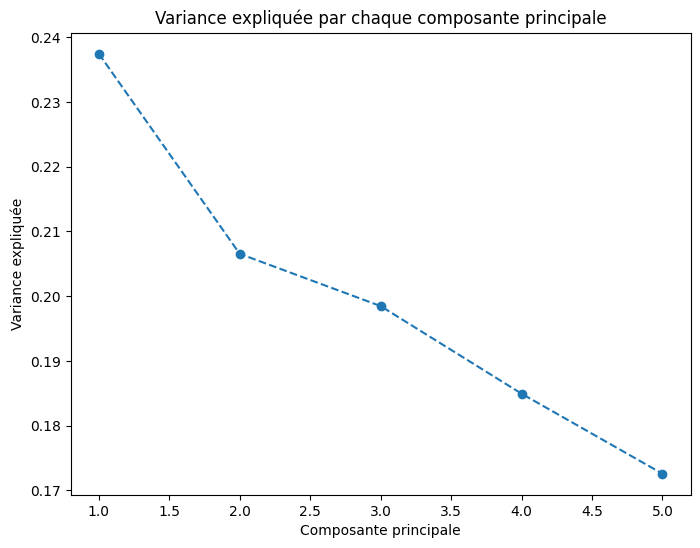

In [25]:
# Affichage de la variance expliquée
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Variance expliquée par chaque composante principale')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.show()




C:\Users\eya_m\AppData\Local\Temp\ipykernel_26056\3603018681.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(categories))  # Génération d'une palette de couleurs


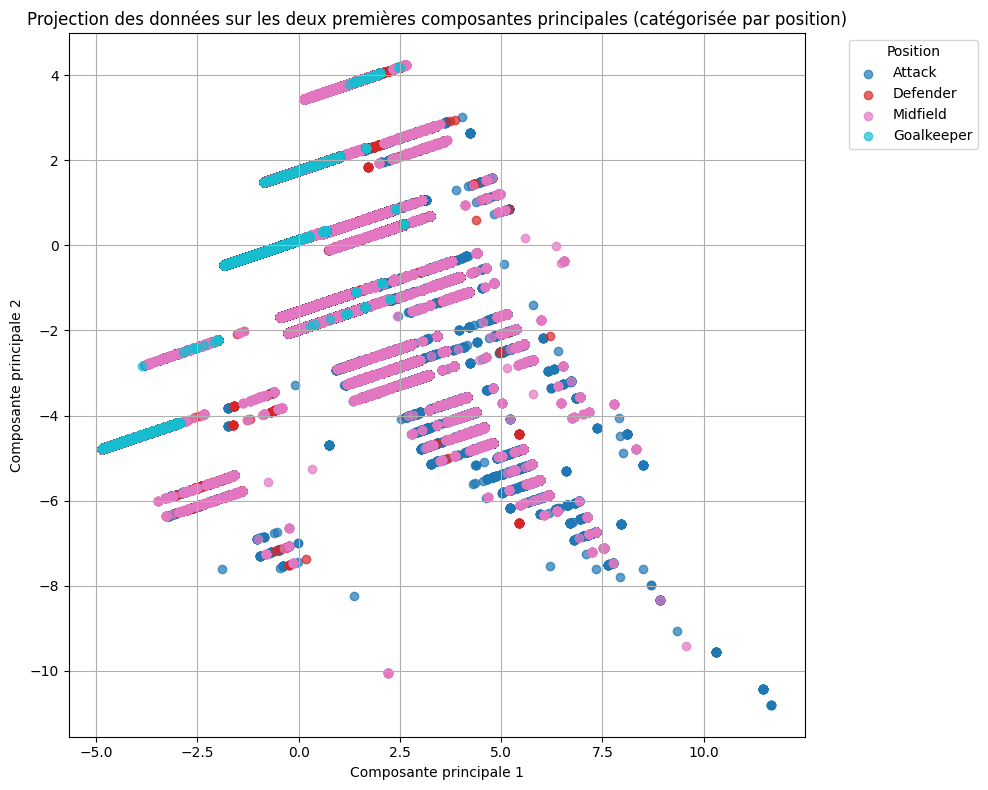

In [26]:

# Ajout des deux premières composantes dans le DataFrame d'origine
df_cleaned['PC1'] = pca_result[:, 0]
df_cleaned['PC2'] = pca_result[:, 1]

# Filtrage pour exclure la catégorie "missing"
df_cleaned_filtered = df_cleaned[df_cleaned['position'] != 'Missing']

# Création du scatter plot avec des couleurs par 'position'
plt.figure(figsize=(10, 8))
categories = df_cleaned_filtered['position'].unique()  # Liste des positions uniques
cmap = cm.get_cmap('tab10', len(categories))  # Génération d'une palette de couleurs
#cmap = plt.colormaps.get_cmap('tab10', len(categories))  # Génération d'une palette de couleurs

for i, category in enumerate(categories):
    subset = df_cleaned_filtered[df_cleaned_filtered['position'] == category]
    plt.scatter(subset['PC1'], subset['PC2'], label=category, alpha=0.7, color=cmap(i))

plt.title('Projection des données sur les deux premières composantes principales (catégorisée par position)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()



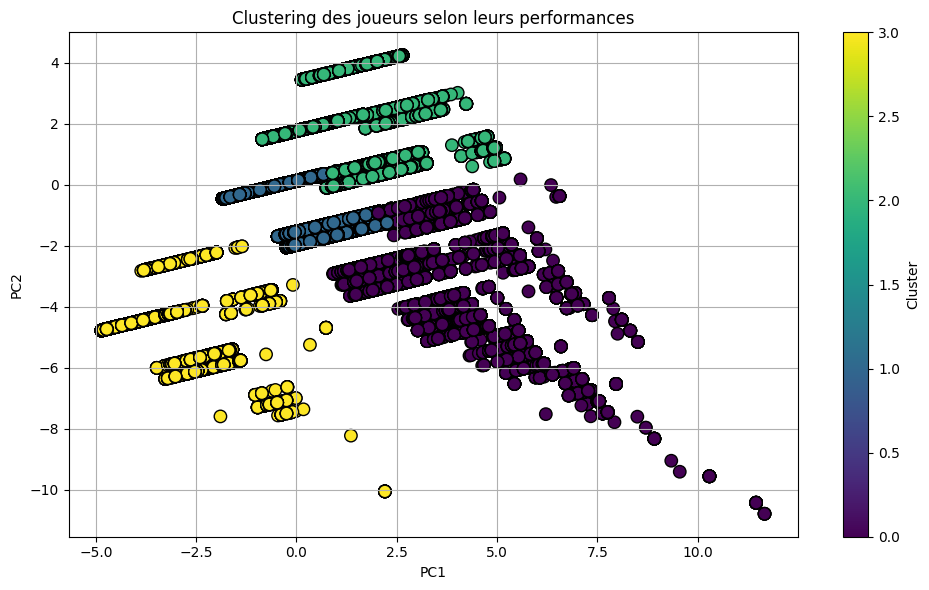

In [27]:
# Clustering des joueurs avec K-means
kmeans = KMeans(n_clusters=4, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(data_scaled)

# Affichage du scatter plot après clustering, colorié par clusters
plt.figure(figsize=(10, 6))
scatter_cluster = plt.scatter(
    df_cleaned['PC1'], df_cleaned['PC2'], 
    c=df_cleaned['Cluster'], cmap='viridis', edgecolor='k', s=80
)

# Ajout de la légende et du colorbar
plt.colorbar(scatter_cluster, label="Cluster")
plt.title('Clustering des joueurs selon leurs performances')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# Affichage du graphique
plt.tight_layout()
plt.show()


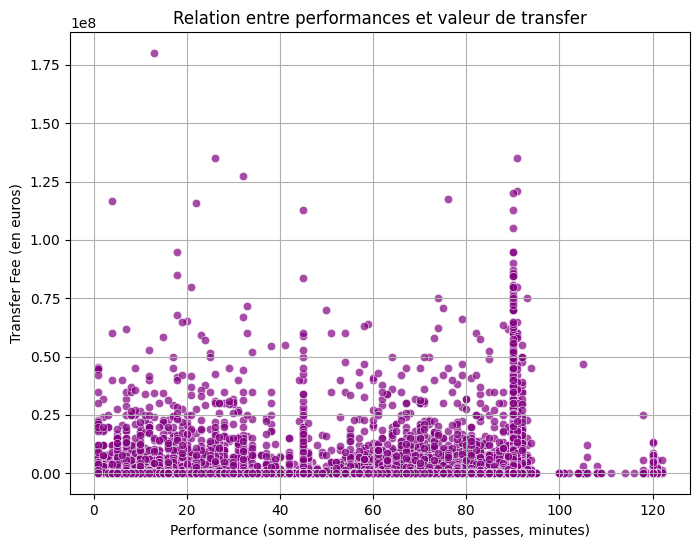

In [ ]:
# Calcul des performances globales (somme des buts, passes et minutes jouées)
df_cleaned['total_performance'] = df_cleaned['goals'] + df_cleaned['assists'] + df_cleaned['minutes_played']

# nous sélectionnons les lignes correspondant aux joueurs de 'appearances'.
transfer_fee = transfers['transfer_fee'][:len(df_cleaned)]

# Relation entre les performances et la valeur marchande
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_cleaned['total_performance'],
    y=transfer_fee,
    alpha=0.7,
    color='purple'
)
plt.title("Relation entre performances et valeur de transfer")
plt.xlabel("Performance (somme normalisée des buts, passes, minutes)")
plt.ylabel("Transfer Fee (en euros)")
plt.grid(True)
plt.show()
